# 1. Import Python modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import pathlib
import random
import seaborn

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten,Activation, BatchNormalization,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score

from utilsData import *
from utilsModel import *

from DeepProbabilisticScaling import *

# 2. Load datasets and pre-trained model

# Configs

In [2]:
model_name = "pneumoniaMNIST"
data_path = "data/"

epsilon = 0.03

# 2. Load data and pre-trained model

In [3]:

X = np.load(data_path + model_name + "_Images.npy")
Y = np.load(data_path + model_name + "_Labels.npy")


X_train = np.load(data_path + model_name +"_trainX.npy")
Y_train = np.load(data_path + model_name +"_trainY.npy")
X_test = np.load(data_path + model_name +"_testX.npy")
Y_test = np.load(data_path + model_name +"_testY.npy")
X_cal = np.load(data_path + model_name +"_calX.npy")
Y_cal = np.load(data_path + model_name +"_calY.npy")

model = keras.models.load_model(f"models/{model_name}.keras")


# 3. Pre-trained model evaluation

55/55 [==============================] - 16s 292ms/step


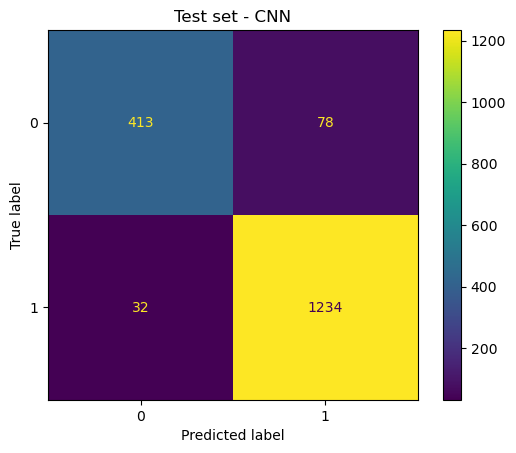

ACC = 0.9373932840068299, F1 = 0.9573312645461598, PPV = 0.9405487804878049, NPV = 0.9280898876404494, TPR = 0.9747235387045814, TNR = 0.8411405295315683

FPR = 0.15885947046843177, FNR = 0.02527646129541864
TP = 1234, FP = 78, TN = 413, FN = 32


In [4]:
p_ts, y_pred_ts, accuracy,f1,PPV,NPV,TPR,TNR,FPR,FNR = EvaluateModel(model, X_test, Y_test)

# 4. Probabilistic Scaling

## 4.1 Calibration data exploration

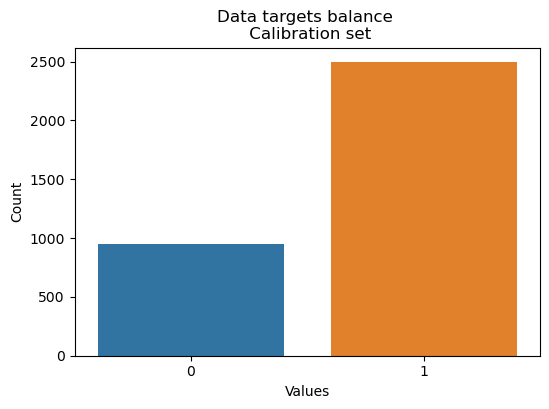

In [5]:
Y_cal_series = pd.Series(Y_cal.squeeze())

# Count the occurrences of each value
value_counts_cal = Y_cal_series.value_counts()

# Create a bar plot using Seaborn
plt.figure(figsize=(6, 4))
sns.barplot(x=value_counts_cal.index, y=value_counts_cal.values)
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Data targets balance \n Calibration set')
plt.show()

## 7.2 Computing $\bar\rho$

In [6]:
rho_bar, rho_bar01, qhat = ComputeRhoBar(model, X_cal, Y_cal, epsilon)

108/108 [==============================] - 33s 302ms/step


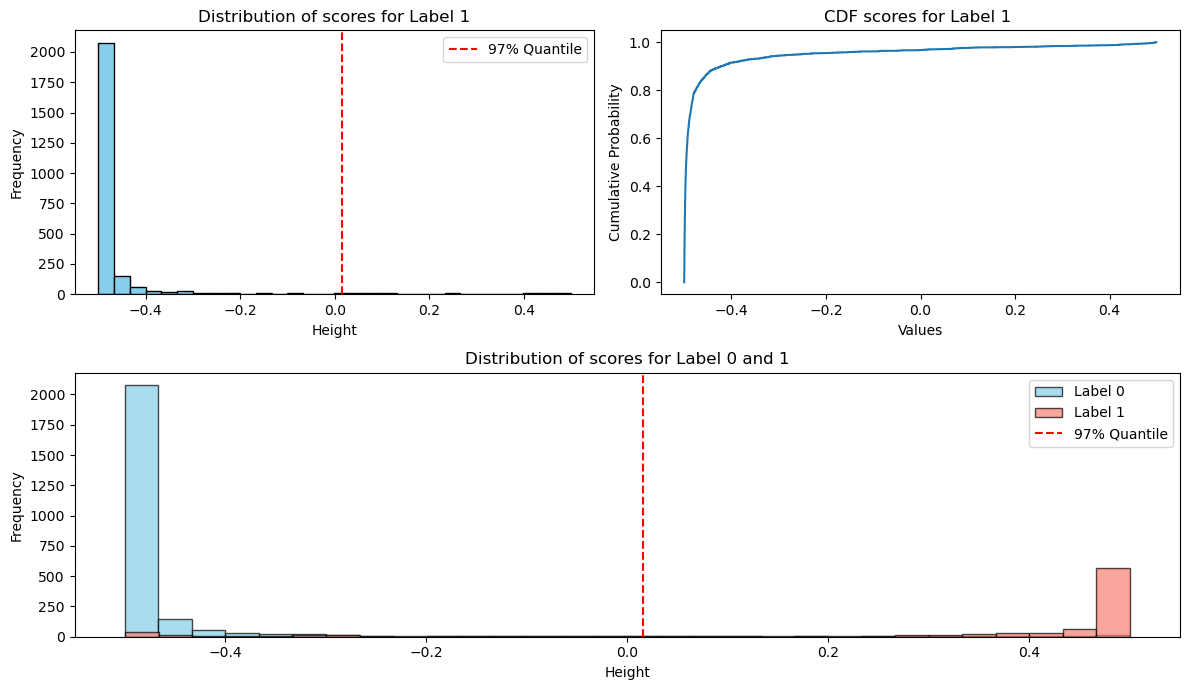

In [7]:
plt.figure(figsize=(12, 7))
ax1 = plt.subplot(2,2,1)  
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)
fontsize = 14

ax1.hist(rho_bar, bins=30, color='skyblue', edgecolor='black')
ax1.axvline(x=qhat, color='r', linestyle='--', label=f'{1-epsilon:.0%} Quantile')
ax1.set_title('Distribution of scores for Label 1')
ax1.set_xlabel('Height')
ax1.set_ylabel('Frequency')
ax1.legend()

# Calculate the cumulative distribution function (CDF)
sorted_rho_bar = np.sort(rho_bar)
cumulative_counts = np.cumsum(np.ones_like(sorted_rho_bar))

# Normalize to get the cumulative probability
cumulative_prob = cumulative_counts / len(rho_bar)

# Plot the CDF
ax2.step(sorted_rho_bar, cumulative_prob, where='post')
ax2.set_xlabel('Values')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('CDF scores for Label 1 ')

# Histogram for label 0
ax3.hist(rho_bar01[Y_cal.squeeze() == 1], bins=30, color='skyblue', edgecolor='black', label='Label 0', alpha=0.7)
# Histogram for label 1
ax3.hist(rho_bar01[Y_cal.squeeze() == 0], bins=30, color='salmon', edgecolor='black', label='Label 1', alpha=0.7)
ax3.axvline(x=qhat, color='r', linestyle='--', label=f'{1-epsilon:.0%} Quantile')
ax3.set_title('Distribution of scores for Label 0 and 1')
ax3.set_xlabel('Height')
ax3.set_ylabel('Frequency')
plt.legend()


plt.tight_layout()

## 7.3 Computing $\rho^*$

In [8]:
n_c = len(Y_cal.squeeze())
rho_star, rho_bar_sorted = ComputeRhoStar(rho_bar, epsilon, n_c)
print('rho_star = ',rho_star)

rho_star =  0.13123178


In [9]:
rho_bar.shape

(2494,)

## 7.4 Visualizing $\rho^*$

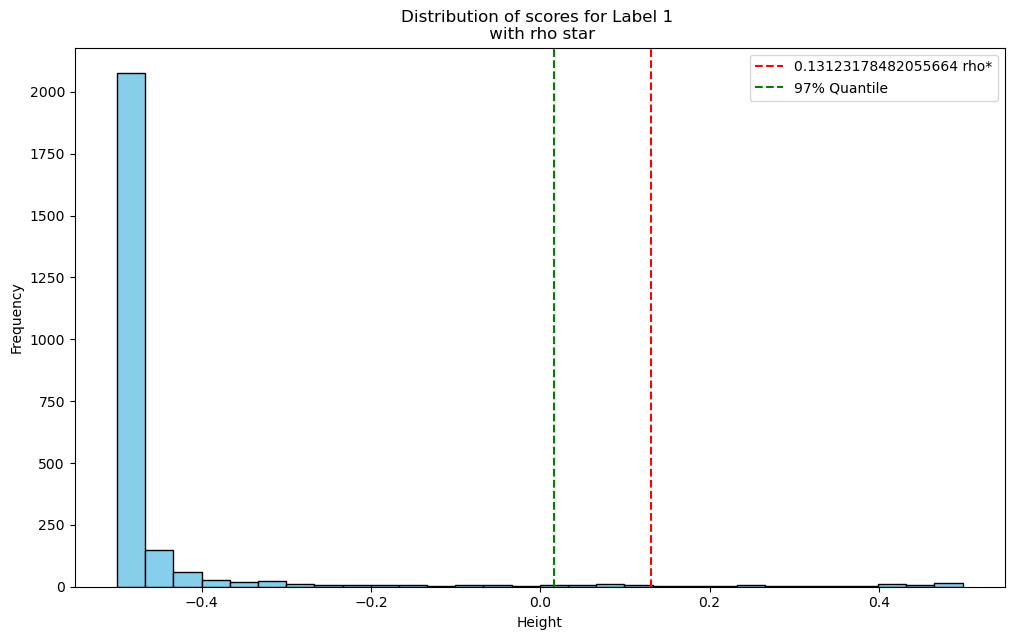

In [10]:
plt.figure(figsize=(12, 7))
fontsize = 14

plt.hist(rho_bar, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=rho_star, color='r', linestyle='--', label=f'{rho_star:} rho*')
plt.axvline(x=qhat, color='g', linestyle='--', label=f'{1-epsilon:.0%} Quantile')
plt.title('Distribution of scores for Label 1 \n with rho star')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.legend()

## 7.5 Evaluate scaling

ACC = 0.9368241320432555, F1 = 0.9573568958893585, PPV = 0.9319371727748691, NPV = 0.9523809523809523, TPR = 0.9842022116903634, TNR = 0.814663951120163

FPR = 0.18533604887983707, FNR = 0.01579778830963665
TP = 1246, FP = 91, TN = 400, FN = 20


<Figure size 1200x800 with 0 Axes>

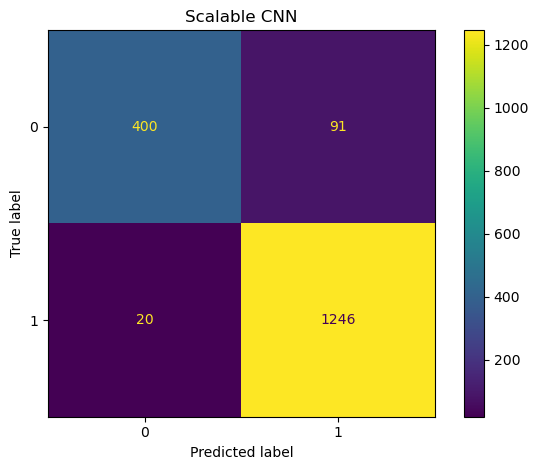

In [11]:
p_ts_star, y_pred_ts_eps, accuracy,f1,PPV,NPV,TPR,TNR,FPR,FNR = EvaluateScalingModel(model,rho_star,p_ts, X_test, Y_test)

## 7.6 Tons of $\varepsilon$

In [12]:
Epsilon = np.linspace(epsilon, 0.5, 100)

FPR_plt = []
FNR_plt = []
TN_plt = []

for eps in Epsilon:
        
    r1 = np.ceil(eps*n_c/2)
    rho_star1 = rho_bar_sorted[int(r1)]
    
    p_ts_star = p_ts + rho_star1
    
    y_pred_ts_eps = []

    for p in p_ts_star:
        if p<0:
            y_pred_ts_eps.append(0)
        else:
            y_pred_ts_eps.append(1)

    TN, FP, FN, TP = confusion_matrix(Y_test, y_pred_ts_eps).ravel()

    FPR = FP/(FP+TN)
    FNR = FN/(FN+TP)
    
    FPR_plt.append(FPR)
    FNR_plt.append(FNR)
    TN_plt.append(TN)
   
    #print(f"FPR = {FPR}, FNR = {FNR}")

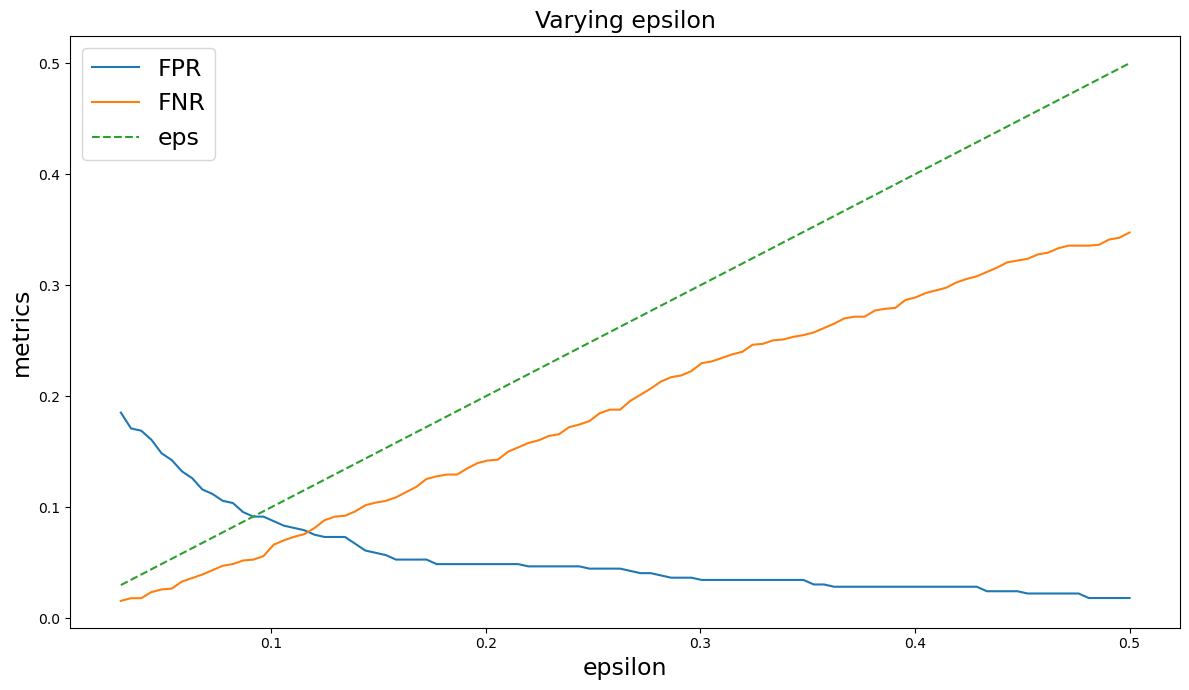

In [13]:
plt.figure(figsize=(12, 7))
fontsize = 17

plt.plot(Epsilon, FPR_plt, label = 'FPR')
plt.plot(Epsilon, FNR_plt, label = 'FNR')
plt.plot(Epsilon, Epsilon, label = 'eps', linestyle='--')
plt.title('Varying epsilon', fontsize=fontsize)
plt.xlabel('epsilon', fontsize=fontsize)
plt.ylabel('metrics', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()

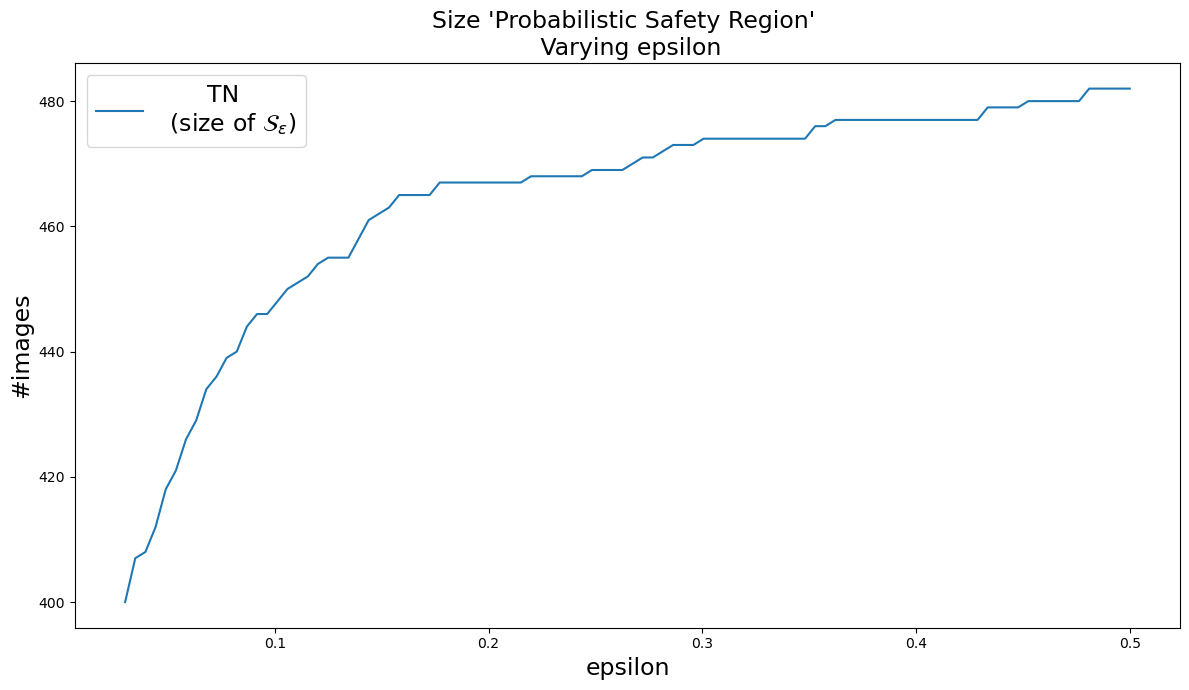

In [14]:
plt.figure(figsize=(12, 7))
fontsize = 17

plt.plot(Epsilon, TN_plt, label = '      TN\n (size of $\mathcal{S}_\epsilon$)')
plt.title('Size \'Probabilistic Safety Region\' \n Varying epsilon', fontsize=fontsize)
plt.xlabel('epsilon', fontsize=fontsize)
plt.ylabel('#images', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()

## 7.7 Random Ideas

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


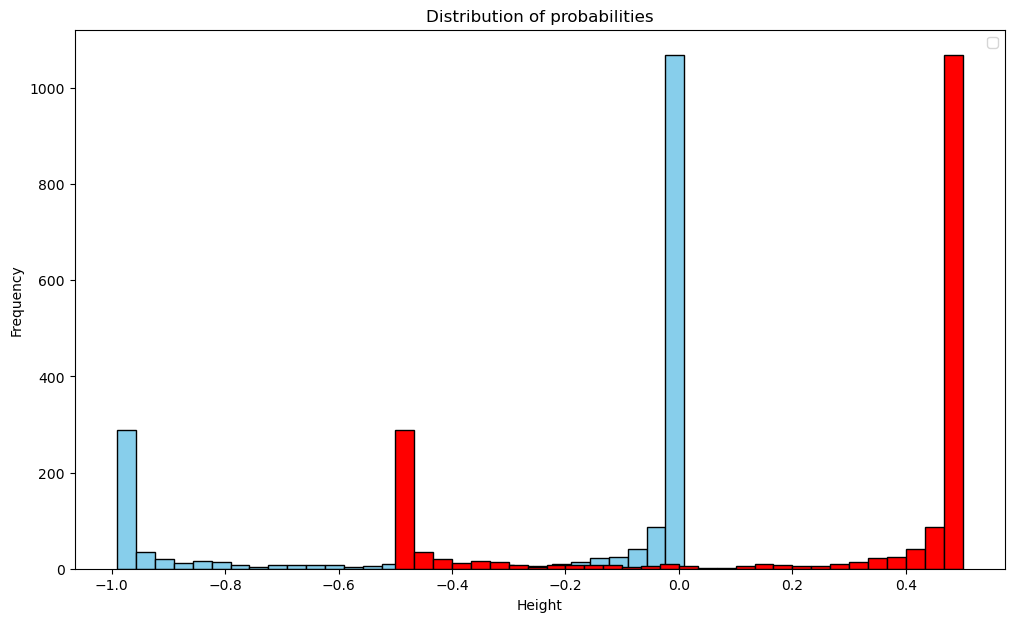

In [15]:
plt.figure(figsize=(12, 7))
fontsize = 14

plt.hist(p_ts_star, bins=30, color='skyblue', edgecolor='black')

plt.hist(p_ts, bins=30, color='red', edgecolor='black')


plt.title('Distribution of probabilities')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.legend()

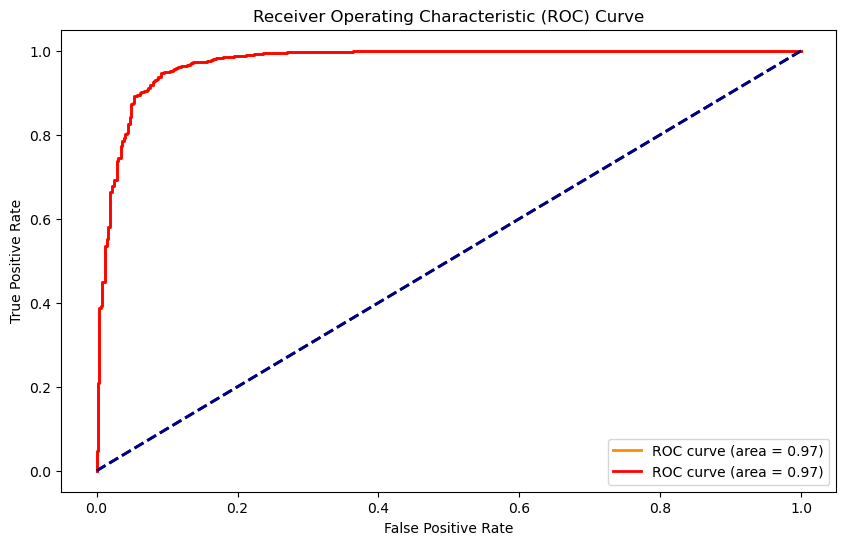

In [16]:
# Get predicted probabilities for the positive class


# Compute ROC curve and AUC
fpr_star, tpr_star, thresholds_star = metrics.roc_curve(Y_test, p_ts_star)
roc_auc_star = auc(fpr_star, tpr_star)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, p_ts)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_star, tpr_star, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_star))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot ROC curve
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()